# Description du Notebook

Ce notebook permet d'entraîner un modèle de NER en français avec spaC en se basant les infos de voyage. 

Les étapes incluent : 
- l'importation, le nettoyage et la préparation des données annotées,
- l'entraînement du modèle. 

Ensuite, on fait un comparaison de performances entre le modèle personnalisé et le modèle spaCy préentraîné, avec des visualisations pour évaluer la diversité et le nombre d'entités détectées par chaque modèle.


{'tokens': 'tokens', 'ner_tags': 'ner_tags', 'spacy_ner_tags': 'spacy_ner_tags'}
Erreur de conversion pour la valeur: tokens. Erreur: malformed node or string on line 1: <ast.Name object at 0x00000173582C0CD0>
Tokens mal formatés dans l'exemple: {'tokens': 'tokens', 'ner_tags': 'ner_tags', 'spacy_ner_tags': 'spacy_ner_tags'}
Erreur de conversion pour la valeur: ["Comment", "me", "rendre", "à", "SAINT-MARTIN-D"HÈRES", "depuis", "NEVERS", "?"]. Erreur: unterminated string literal (detected at line 1) (<unknown>, line 1)
Tokens mal formatés dans l'exemple: {'tokens': '[\'Comment\', \'me\', \'rendre\', \'à\', "SAINT-MARTIN-D\'HÈRES", \'depuis\', \'NEVERS\', \'?\']', 'ner_tags': '[0, 0, 0, 0, 3, 0, 1, 0]', 'spacy_ner_tags': "[{'start': 48, 'end': 54, 'label': 'DEP'}, {'start': 20, 'end': 40, 'label': 'ARR'}]"}
Erreur de conversion pour la valeur: ["Indique", "-moi", "le", "chemin", "depuis", "PETIT-BOURG", "jusqu"", "à", "SAINT-FONS", "."]. Erreur: unterminated string literal (detected at l

C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Trouve un itinéraire pour aller à TASSIN - LA - DE..." with entities "[(34, 53, 'ARR')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
C:\Users\vikne\anaconda3\Lib\site-packages\spacy\training\iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Quels sont les trajets de jour disponibles entre T..." with entities "[(49, 68, 'DEP')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Losses at iteration 0 : {'ner': 646.1158461416817}
Losses at iteration 1 : {'ner': 262.16927003597084}
Losses at iteration 2 : {'ner': 230.22696028767083}
Losses at iteration 3 : {'ner': 210.9225089765187}
Losses at iteration 4 : {'ner': 182.66592238095365}
F1 Score: 0.484472049689441, Precision: 0.4936708860759494, Recall: 0.47560975609756095
Test F1 Score: 0.48750000000000004, Test Precision: 0.4482758620689655, Test Recall: 0.5342465753424658


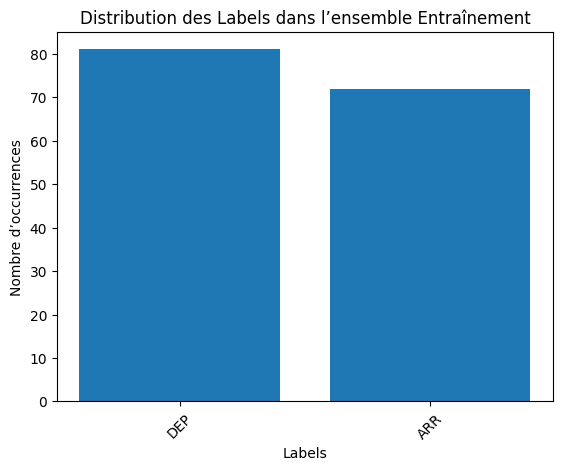

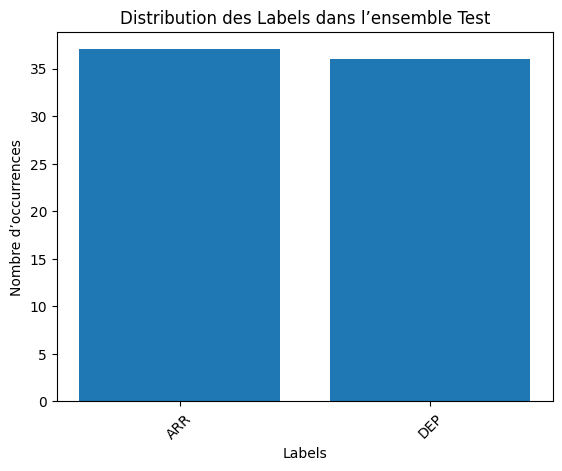

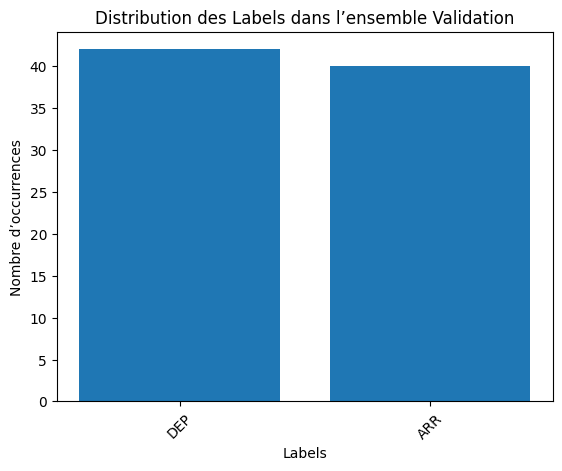

In [11]:
import spacy
from spacy.training import Example
import os
import random
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from spacy.scorer import Scorer
from spacy.util import minibatch, compounding
import numpy as np
import seaborn as sns
from pathlib import Path
import ast  # Importation du module pour l'évaluation sécurisée

# Définir les chemins des répertoires
dataset_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/raw/generated_dataset/token.csv"
model_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/spacy/"

# Création d'un modèle vierge en français
nlp = spacy.blank("fr")

# Récupération du pipeline NER, et ajout si nécessaire
if "ner" not in nlp.pipe_names:
    nlp.add_pipe("ner", last=True)  # Utiliser directement le nom du composant
else:
    ner = nlp.get_pipe("ner")

# Ajout des labels à entraîner
ner.add_label("ARR")  # Exemple d'étiquette pour une entité 'ARR'
ner.add_label("DEP")  # Exemple d'étiquette pour une entité 'DEP'

# Charger le fichier CSV token.csv
dataset = load_dataset('csv', data_files=dataset_path, delimiter=',', column_names=["text", "tokens", "ner_tags", "spacy_ner_tags"])

# Préparer les données
dataset = dataset["train"]
dataset = dataset.remove_columns("text")  # Nous n'avons besoin que des tokens et des entités

# Vérifier les premières lignes
print(dataset[0])

# Fonction pour vérifier l'alignement des entités
def is_entity_well_aligned(text, start, end):
    if start > 0 and text[start-1].isalnum():
        return False
    if end < len(text) and text[end].isalnum():
        return False
    return True

# Fonction pour effectuer une évaluation sécurisée avec ast.literal_eval
def safe_eval(val):
    try:
        return ast.literal_eval(val)  # Tentative de conversion en liste ou dictionnaire
    except (ValueError, SyntaxError) as e:
        print(f"Erreur de conversion pour la valeur: {val}. Erreur: {e}")
        return None

# Préparation des données d'entraînement
CONVERTED_TRAIN_DATA = []
misaligned_examples_count = 0

for item in dataset:
    # Remplacer les guillemets simples par des guillemets doubles pour rendre la chaîne JSON compatible
    tokens_str = item['tokens'].replace("'", '"')  # Remplace les guillemets simples par des guillemets doubles
    spacy_ner_tags_str = item['spacy_ner_tags'].replace("'", '"')  # Idem pour les entités
    
    # Utilisation de safe_eval pour convertir les chaînes représentant des listes et des dictionnaires
    tokens = safe_eval(tokens_str)  # Convertir la chaîne de caractères représentant une liste en liste Python
    spacy_ner_tags = item.get('spacy_ner_tags')

    # Vérification si la conversion a échoué pour les tokens ou les spacy_ner_tags
    if tokens is None:
        print(f"Tokens mal formatés dans l'exemple: {item}")
        continue  # Ignore cet élément s'il y a une erreur dans les tokens

    if spacy_ner_tags not in (None, 'None', ''):
        annotations = safe_eval(spacy_ner_tags_str)  # Convertir la chaîne représentant un dictionnaire en objet Python
        
        if annotations is not None:
            entities = []
            for annotation in annotations:
                start, end = annotation['start'], annotation['end']
                if is_entity_well_aligned(" ".join(tokens), start, end):
                    entities.append((start, end, annotation['label']))
            CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": entities}))
        else:
            misaligned_examples_count += 1
            CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": []}))
    else:
        misaligned_examples_count += 1
        CONVERTED_TRAIN_DATA.append((" ".join(tokens), {"entities": []}))

print(f"Nombre d'exemples mal alignés ignorés: {misaligned_examples_count}")

# Création des exemples spaCy
examples = []
for text, annots in CONVERTED_TRAIN_DATA:
    try:
        doc = nlp.make_doc(text)
        examples.append(Example.from_dict(doc, annots))
    except ValueError:
        continue

# Séparer les données en train, validation, test
train_data, test_valid_data = train_test_split(examples, test_size=0.5, random_state=42)
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)

# Entraînement
with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.begin_training()  # Utiliser begin_training() pour un modèle vierge
    for i in range(5):  # Nombre d'itérations
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            nlp.update(batch, drop=0.5, losses=losses, sgd=optimizer)
        print("Losses at iteration", i, ":", losses)

# Évaluation du modèle
def evaluate(nlp, examples):
    scorer = Scorer()
    examples_to_score = []
    for example in examples:
        pred_doc = nlp(example.text)
        scored_example = Example(pred_doc, example.reference)
        examples_to_score.append(scored_example)
    scores = scorer.score(examples_to_score)
    return scores

# Evaluer les scores sur les données de validation
valid_scores = evaluate(nlp, valid_data)
print(f"F1 Score: {valid_scores['ents_f']}, Precision: {valid_scores['ents_p']}, Recall: {valid_scores['ents_r']}")

# Sauvegarde du modèle
output_dir = Path("C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/models/spacy/spacy_model")
output_dir.mkdir(parents=True, exist_ok=True)
nlp.to_disk(output_dir)

# Évaluation sur les données de test
test_scores = evaluate(nlp, test_data)
print(f"Test F1 Score: {test_scores['ents_f']}, Test Precision: {test_scores['ents_p']}, Test Recall: {test_scores['ents_r']}")

# Affichage des résultats sous forme de graphique
def plot_label_distribution(examples, label="Entraînement"):
    label_counts = Counter([ent.label_ for example in examples for ent in example.reference.ents])
    labels, counts = zip(*label_counts.items())
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Nombre d’occurrences')
    plt.title(f'Distribution des Labels dans l’ensemble {label}')
    plt.xticks(rotation=45)
    plt.show()

# Visualiser la distribution des étiquettes
plot_label_distribution(train_data, "Entraînement")
plot_label_distribution(test_data, "Test")
plot_label_distribution(valid_data, "Validation")
